# 1. SETTINGS

In [1]:
# libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb

In [2]:
# warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
# pandas options
pd.set_option("display.max_columns", None)

# 2. IMPORT

In [ ]:
# data name (used for saving files too)
data_name = "data_v4_0_60"

In [4]:
# import datasets
data = pd.read_csv("../data/prepared/" + str(data_name) + ".csv", compression = "gzip")

In [5]:
# check data
print("Dimensions:", data.shape)
data.head()

Dimensions: (62231886, 45)


,PredictionIdx,CustomerIdx,IsinIdx,BuySell,CustomerInterest,Week,Recency1,Recency2,Recency3,Recency4,Recency5,Recency6,Recency1isLowerRecency2,Recency2isLowerRecency4,Frequency1,Frequency2,Frequency3,Frequency4,Frequency5,Frequency6,Frequecny1isLowerFrequency2,Frequecny2isLowerFrequency4,Month,Buy,Asset Managers & Hedge Funds,Asset Owners,Banks and Intermediaries,Corporation,Official Institution - OI,Americas,Asia Pacific,"Europe, Middle East and Africa",FLOW G10,FLOW LOCAL MARKET,SAS & COVERED BONDS,NR,Currency_trend,MeanPrice,StdPrice,MeanYield,StdYield,MeanZScore,StdZScore,YieldMarktDelta,ZScoreMarktDelta
0,NaN,0,16471,Buy,0.0,61,120.0,119.0,2.0,1.0,1.0,1.0,0,0,0.0,0.0,0.083333,0.183333,0.333333,0.666667,0,1,2,1,1,0,0,0,0,0,1,0,0,1,0,0,1.0,105.323953,1.333736,3.085399,3.358929,1.903997,3.207112,0.035272,0.280414
1,NaN,0,16471,Buy,0.0,62,120.0,119.0,3.0,2.0,2.0,2.0,0,0,0.0,0.0,0.081967,0.180328,0.327869,0.655738,0,1,2,1,1,0,0,0,0,0,1,0,0,1,0,0,1.0,105.323953,1.333736,3.085399,3.358929,1.903997,3.207112,0.035272,0.280414
2,NaN,0,16471,Buy,0.0,63,120.0,119.0,1.0,1.0,3.0,3.0,0,0,0.0,0.0,0.096774,0.193548,0.322581,0.645161,0,1,2,1,1,0,0,0,0,0,1,0,0,1,0,0,1.0,105.323953,1.333736,3.085399,3.358929,1.903997,3.207112,0.035272,0.280414
3,NaN,0,16471,Buy,0.0,64,120.0,119.0,2.0,2.0,4.0,4.0,0,0,0.0,0.0,0.095238,0.190476,0.317460,0.634921,0,1,1,1,1,0,0,0,0,0,1,0,0,1,0,0,1.0,105.323953,1.333736,3.085399,3.358929,1.903997,3.207112,0.035272,0.280414
4,NaN,0,16471,Buy,0.0,64,120.0,119.0,2.0,2.0,4.0,4.0,0,0,0.0,0.0,0.095238,0.190476,0.317460,0.634921,0,1,2,1,1,0,0,0,0,0,1,0,0,1,0,0,1.0,105.323953,1.333736,3.085399,3.358929,1.903997,3.207112,0.035272,0.280414


# 3. PREPARATIONS

In [6]:
# check NA
nas = data.isnull().sum()
nas[nas > 0]

PredictionIdx       61747128
CustomerInterest      484758
MeanPrice            5578422
StdPrice             5581544
MeanYield            5578422
StdYield             5581544
MeanZScore           5578422
StdZScore            5581544
YieldMarktDelta      5578422
ZScoreMarktDelta     5578422
dtype: int64

In [7]:
# list of features
excluded_features = ["PredictionIdx", "CustomerIdx", "IsinIdx", "BuySell", "Week", "CustomerInterest"]
features = [var for var in data.columns if var not in excluded_features]
len(features)

39

In [8]:
# drop high recency from train
data = data[(data.Week == 121) | (data.Recency1 < data.Recency1.max())]

In [9]:
### data partitioning

# training
X_train = data.loc[data.Week < 120]
y_train = data.loc[data.Week < 120].CustomerInterest

# validation
X_valid = data.loc[data.Week == 120]
y_valid = data.loc[data.Week == 120].CustomerInterest

# test set
test = data.loc[data.Week == 121]

# 4. MODELING - STAGE 1

In [13]:
### PARAMETERS

# parallel settings
cores = 24

# learner settings
metric   = "auc"
verbose  = 250
stopping = 100

# lightGBM
gbm = lgb.LGBMClassifier(n_estimators     = 10000,
                         learning_rate    = 0.005,
                         num_leaves       = 70,
                         colsample_bytree = 0.8,
                         subsample        = 0.9,
                         max_depth        = 7,
                         reg_alpha        = 0.1,
                         reg_alambda      = 0.1,
                         min_split_gain   = 0.01,
                         min_child_weight = 2,
                         random_state     = 42,
                         num_threads      = cores)

In [14]:
# train lightGBM
gbm = gbm.fit(X_train[features], y_train, 
              eval_set = [(X_train[features], y_train), 
                          (X_valid[features], y_valid)], 
              eval_metric = metric, verbose = verbose, 
              early_stopping_rounds = stopping)
    
# save number of iterations
num_iters = gbm.best_iteration_  


##### RESULTS

# k = 61 (v2), drop 0 weeks, train = from 80 week, 1k iter, stop = 100 (not met):      0.83679  (0.77887 LB)
# k = 61 (v2), drop 0 weeks, train = from 80 week, 3k iter, stop = 100 (not met):      0.840938 (0.78581 LB)
# k = 61 (v2), drop 0 weeks, train = from 80 week, 5k iter, stop = 100 (not met):      0.841801 (0.78626 LB)
# k = 61 (v2), drop 0 weeks, train = from 80 week, 10k iter, stop = 100 (met):         0.841866 (0.78626 LB)

# k = 62 (v2+v3), drop 0 weeks, train = from 80 week, 10k iter, stop = 100 (met):      0.842258 ()
# k = 38 (v3),    drop 0 weeks, train = from 80 week, 5k iter,  stop = 100 (not met):  0.843073 (0.78504 LB)
# k = 39 (v3+BS), drop 0 weeks, train = from 80 week, 10k iter, stop = 100 (met):      0.843815 ()
# k = 31 (v2red), drop 0 weeks, train = from 60 week, 10k iter, stop = 100 (not met):  0.844060 ()

# k = 39 (v4), drop 0 weeks, train = from 60  week, 10k iter, stop = 100 (met):        0.844511 ()
# k = 39 (v4), drop 0 weeks, train = from 80  week, 10k iter, stop = 100 (met):        0.845086 (0.78952 LB)
# k = 39 (v4), drop 0 weeks, train = from 100 week, 10k iter, stop = 100 (met):        0.844058 ()

Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.826547	valid_1's auc: 0.829395
[200]	training's auc: 0.827414	valid_1's auc: 0.829967
[300]	training's auc: 0.827985	valid_1's auc: 0.830378
[400]	training's auc: 0.828518	valid_1's auc: 0.831135
[500]	training's auc: 0.829348	valid_1's auc: 0.831936
[600]	training's auc: 0.830134	valid_1's auc: 0.832755
[700]	training's auc: 0.831208	valid_1's auc: 0.833747
[800]	training's auc: 0.832222	valid_1's auc: 0.834554
[900]	training's auc: 0.833302	valid_1's auc: 0.835731
[1000]	training's auc: 0.834333	valid_1's auc: 0.836575
[1100]	training's auc: 0.835332	valid_1's auc: 0.837216
[1200]	training's auc: 0.836231	valid_1's auc: 0.837719
[1300]	training's auc: 0.837166	valid_1's auc: 0.838291
[1400]	training's auc: 0.838001	valid_1's auc: 0.838726
[1500]	training's auc: 0.838726	valid_1's auc: 0.839087
[1600]	training's auc: 0.839408	valid_1's auc: 0.839395
[1700]	training's auc: 0.840064	valid_1's auc: 0.8

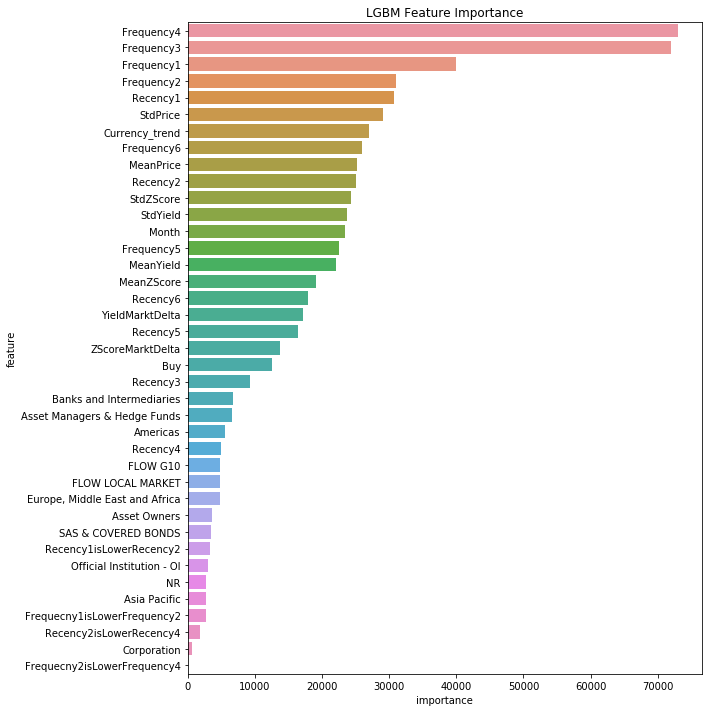

In [15]:
##### VARIABLE IMPORTANCE

# load variable importance
importance = pd.DataFrame()
importance["feature"] = features
importance["importance"] = gbm.feature_importances_

# plot variable importance
plt.figure(figsize = (10, 10))
sns.barplot(x = "importance", y = "feature", data = importance.sort_values(by = "importance", ascending = False))
plt.title('LGBM Feature Importance')
plt.tight_layout()

# save plot as pdf
plt.savefig("../var_importance.pdf")

In [16]:
##### PREDICTION

### VALID DATA

# predict validation set
pred_valid = X_valid[["CustomerIdx", "IsinIdx", "BuySell", "Week", "CustomerInterest"]]
pred_valid["TARGET"] = gbm.predict_proba(X_valid[features], num_iteration = num_iters)[:, 1]
auc = roc_auc_score(y_valid, pred_valid.TARGET)

# export CSV
pred_valid.to_csv("../pred_valid/auc" + str(round(auc, 6))[2:8] + "_" + str(data_name) + "_lgb.csv", 
                  index = False, float_format = "%.8f")


### TEST DATA

# predict test set
test["TARGET"] = gbm.predict_proba(test[features], num_iteration = num_iters)[:, 1]

# check rank correlation with the best submission
from scipy.stats import spearmanr
best = pd.read_csv("../submissions/rankmean_4_submits.csv")
best = best.merge(test[["PredictionIdx", "TARGET"]], how = "left", on = "PredictionIdx")
print(spearmanr(best["TARGET"], best.CustomerInterest))

# export CSV
subm = best[["PredictionIdx", "TARGET"]]
subm.columns =["PredictionIdx", "CustomerInterest"]
best.to_csv("../submissions/auc" + str(round(auc, 6))[2:8] + "_" + str(data_name) + "_lgb_1stage.csv", 
            index = False, float_format = "%.8f")

SpearmanrResult(correlation=0.9491665786155001, pvalue=0.0)

# 5. MODELING - STAGE 2

In [14]:
# keep top100 features
top = 100
features = list(importance["feature"][0:np.min([top, len(features)])])

In [17]:
# use full data as train
X_train = data.loc[data.Week <= 120]
y_train = data.loc[data.Week <= 120].CustomerInterest

## LIGHT GBM

In [ ]:
### retrain model with the best iters

# lightGBM
gbm = lgb.LGBMClassifier(n_estimators     = num_iters,
                         learning_rate    = 0.005,
                         num_leaves       = 70,
                         colsample_bytree = 0.8,
                         subsample        = 0.9,
                         max_depth        = 7,
                         reg_alpha        = 0.1,
                         reg_alambda      = 0.1,
                         min_split_gain   = 0.01,
                         min_child_weight = 2,
                         random_state     = 42,
                         num_threads      = cores)

# train lightGBM
gbm = gbm.fit(X_train[features], y_train, 
              eval_set = [(X_train[features], y_train)], 
              eval_metric = metric, verbose = verbose)

[100]	training's auc: 0.826556
[200]	training's auc: 0.827496
[300]	training's auc: 0.828018
[400]	training's auc: 0.828606
[500]	training's auc: 0.82941
[600]	training's auc: 0.83023
[700]	training's auc: 0.831287
[800]	training's auc: 0.832303
[900]	training's auc: 0.833393
[1000]	training's auc: 0.834429
[1100]	training's auc: 0.835398
[1200]	training's auc: 0.836289
[1300]	training's auc: 0.837204
[1400]	training's auc: 0.838027
[1500]	training's auc: 0.838742
[1600]	training's auc: 0.839427
[1700]	training's auc: 0.840075
[1800]	training's auc: 0.840715
[1900]	training's auc: 0.841274
[2000]	training's auc: 0.841811
[2100]	training's auc: 0.842314
[2200]	training's auc: 0.842781
[2300]	training's auc: 0.843248


In [ ]:
# predict test set
test["TARGET"] = gbm.predict_proba(test[features], num_iteration = num_iters)[:, 1]

In [ ]:
# check rank correlation with the best submission
from scipy.stats import spearmanr
best = pd.read_csv("../submissions/rankmean_4_submits.csv")
best = best.merge(test[["PredictionIdx", "TARGET"]], how = "left", on = "PredictionIdx")
spearmanr(best["TARGET"], best.CustomerInterest)

In [ ]:
# export CSV
subm = best[["PredictionIdx", "TARGET"]]
subm.columns = ["PredictionIdx", "CustomerInterest"]
subm.to_csv("../submissions/auc" + str(round(auc, 6))[2:8] + "_" + str(data_name) + "_lgb_2stage.csv", 
            index = False, float_format = "%.8f")